# Machine Learning Project : Drowsiness Detection


## Stage 1 : Data Cleaning and Preprocessing



### Data Exploration and Understanding

In [1]:
import os
import numpy as np
import pandas as pd
from skimage.exposure import equalize_adapthist
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import hashlib

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dheerajperumandla/drowsiness-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\hbonn\.cache\kagglehub\datasets\dheerajperumandla\drowsiness-dataset\versions\1


First of all let's explore the dataset and understand it.

We are going to check the dataset structure and size.

In [3]:
labels = os.listdir(path+"/train")
labels

['Closed', 'no_yawn', 'Open', 'yawn']

Our dataset is composed of 4 directories each constituting images of a certain label. Let's check the size of the data to see whether it's balanced or not.

In [4]:
count = 0
def get_size(start_path = '.'):
    total_size = 0
    for path in os.listdir(start_path):
        if os.path.isfile(os.path.join(start_path, path)):
            total_size +=1
    return total_size
print("Closed size:",get_size(path+"/train/Closed"))
print("Open size:",get_size(path+"/train/Open"))
print("Yawn size:",get_size(path+"/train/yawn"))
print("No yawn size:",get_size(path+"/train/no_yawn"))

Closed size: 726
Open size: 726
Yawn size: 723
No yawn size: 725


The data is balanced: We have the same distribution between classes (726 for bot closed and open and 723/725 for yawn and no yawn respectively)

Usually, to explore data in the form of a dataframe, we do df.head(). Here, we try to visualize the first couple of images of each label.

<Figure size 640x480 with 0 Axes>

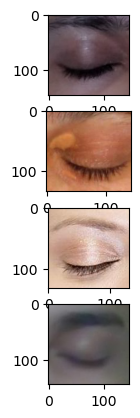

In [5]:
import matplotlib.pyplot as plt
plt.figure()
f, axarr = plt.subplots(4,1)

axarr[0].imshow(plt.imread(path+"/train/Closed/_0.jpg"))
axarr[1].imshow(plt.imread(path+"/train/Closed/_1.jpg"))
axarr[2].imshow(plt.imread(path+"/train/Closed/_2.jpg"))
axarr[3].imshow(plt.imread(path+"/train/Closed/_3.jpg"))

<Figure size 640x480 with 0 Axes>

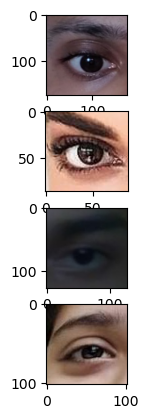

In [6]:
plt.figure()
f, axarr = plt.subplots(4,1)

axarr[0].imshow(plt.imread(path+"/train/Open/_0.jpg"))
axarr[1].imshow(plt.imread(path+"/train/Open/_1.jpg"))
axarr[2].imshow(plt.imread(path+"/train/Open/_2.jpg"))
axarr[3].imshow(plt.imread(path+"/train/Open/_3.jpg"))

<Figure size 640x480 with 0 Axes>

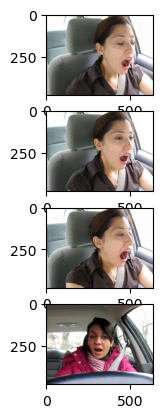

In [7]:
plt.figure()
f, axarr = plt.subplots(4,1)

axarr[0].imshow(plt.imread(path+"/train/yawn/1.jpg"))
axarr[1].imshow(plt.imread(path+"/train/yawn/2.jpg"))
axarr[2].imshow(plt.imread(path+"/train/yawn/3.jpg"))
axarr[3].imshow(plt.imread(path+"/train/yawn/4.jpg"))

<Figure size 640x480 with 0 Axes>

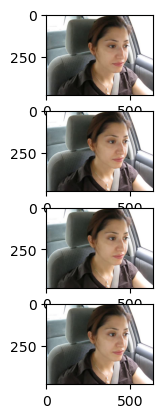

In [8]:
plt.figure()
f, axarr = plt.subplots(4,1)

axarr[0].imshow(plt.imread(path+"/train/no_yawn/1.jpg"))
axarr[1].imshow(plt.imread(path+"/train/no_yawn/2.jpg"))
axarr[2].imshow(plt.imread(path+"/train/no_yawn/3.jpg"))
axarr[3].imshow(plt.imread(path+"/train/no_yawn/4.jpg"))

Let's check the image shape.

In [9]:
a = plt.imread(path+"/train/Closed/_0.jpg")
display(a.shape)

a1 = plt.imread(path+"/train/Closed/_1.jpg")
display(a1.shape)

b = plt.imread(path+"/train/Open/_0.jpg")
display(b.shape)

b1 = plt.imread(path+"/train/Open/_1.jpg")
display(b1.shape)

c = plt.imread(path+"/train/yawn/1.jpg")
display(c.shape)

c1 = plt.imread(path+"/train/yawn/2.jpg")
display(c1.shape)

d = plt.imread(path+"/train/no_yawn/1.jpg")
display(d.shape)

d1 = plt.imread(path+"/train/no_yawn/2.jpg")
display(d1.shape)

(145, 145, 3)

(135, 142, 3)

(175, 175, 3)

(86, 88, 3)

(480, 640, 3)

(480, 640, 3)

(480, 640, 3)

(480, 640, 3)

We can see here that the images are not of the same size.

### Data Cleaning

To clean the data, we usually have to handle missing values and remove duplicates if any.
In this context, it means that we have to check if there are any corrupted files and remove duplicate images.

In [10]:
from PIL import Image
import os

def count_corrupted_images(dataset_path):
    corrupted_count = 0
    total_images = 0

    for root, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            total_images += 1
            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception as e:
                corrupted_count += 1
                print(f"Corrupted: {file_path} - Error: {e}")

    print(f"\nTotal Images Checked: {total_images}")
    print(f"Total Corrupted Images: {corrupted_count}")
    return corrupted_count

count_corrupted_images(path+"/train/Closed")
count_corrupted_images(path+"/train/Open")
count_corrupted_images(path+"/train/yawn")
count_corrupted_images(path+"/train/no_yawn")


Total Images Checked: 726
Total Corrupted Images: 0

Total Images Checked: 726
Total Corrupted Images: 0

Total Images Checked: 723
Total Corrupted Images: 0

Total Images Checked: 725
Total Corrupted Images: 0


0

Great! We don't have any corrupted file.
Let's now check for the duplicates.

In [11]:
import hashlib
import cv2
import os

def remove_duplicates(dataset_path):
    image_hashes = {}
    unique_images = []

    for root, _, files in os.walk(dataset_path):  # Walk through the directory
        for file in files:
            file_path = os.path.join(root, file)  # Get full file path

            # Read the image in grayscale
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            # Convert the NumPy array to bytes before hashing
            img_bytes = img.tobytes()

            # Calculate a hash for the image
            img_hash = hashlib.md5(img_bytes).hexdigest()

            # Check if the hash is already in the dictionary
            if img_hash not in image_hashes:
                image_hashes[img_hash] = file_path
                unique_images.append(file_path)  # Add to unique images
            else:
                return(f"Duplicate found: {file_path}")

    return ("There are no duplicate images")

# Example usage:
# Assuming 'path' is your base dataset path
remove_duplicates(path + "/train/Closed")
remove_duplicates(path + "/train/Open")
remove_duplicates(path + "/train/yawn")
remove_duplicates(path + "/train/no_yawn")

'There are no duplicate images'

### Data Preprocessing

In this step, we will implement some preprocessing techniques such as Normalization, image alignment and Image Transformation.

First of all, we need to load the images so that we can preprocess them and use them in the algorithms. You can see that we resized all the images to the same size to facilitate modeling.

In [12]:
def load_images(dataset_path, target_size=(64, 64)):
    images = []
    labels = []
    for label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, label)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            if img is not None:
                img_resized = cv2.resize(img, target_size)  # Resize to fixed size
                images.append(img_resized.flatten())  # Flatten to 1D vector
                labels.append(label)
    return np.array(images), np.array(labels)

images, labels = load_images(path+'/train')

Let's split the dataset into train and test set.

We will normalize the images so that every pixel is a value between 0 and 1 instead of 0 and 255.

Since we are going to do an image classification, we need to use the LabelEncoder in order to numerize the different labels ( 0, 1, 2 ,3).

In [13]:
X, y = load_images(path+'/train')

X = X / 255.0


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")



Training samples: 2320, Testing samples: 580


## SVM Classifier

In [14]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
# Train SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)

# Evaluate SVM performance
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")

SVM Classification Report:
              precision    recall  f1-score   support

      Closed       0.82      0.87      0.85       151
        Open       0.87      0.81      0.84       150
     no_yawn       0.95      0.99      0.97       141
        yawn       0.99      0.94      0.97       138

    accuracy                           0.90       580
   macro avg       0.91      0.91      0.91       580
weighted avg       0.90      0.90      0.90       580

SVM Accuracy: 0.90


## Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate Random Forest performance
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")


Random Forest Classification Report:
              precision    recall  f1-score   support

      Closed       0.92      0.88      0.90       151
        Open       0.89      0.92      0.90       150
     no_yawn       0.92      1.00      0.96       141
        yawn       1.00      0.92      0.96       138

    accuracy                           0.93       580
   macro avg       0.93      0.93      0.93       580
weighted avg       0.93      0.93      0.93       580

Random Forest Accuracy: 0.93


## Logistic Regression Classifier

In [16]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Evaluate Logistic Regression performance
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

      Closed       0.85      0.92      0.88       151
        Open       0.92      0.83      0.87       150
     no_yawn       0.93      0.99      0.96       141
        yawn       0.99      0.93      0.96       138

    accuracy                           0.92       580
   macro avg       0.92      0.92      0.92       580
weighted avg       0.92      0.92      0.92       580

Logistic Regression Accuracy: 0.92


c:\Users\hbonn\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Here, we see that all these algorithms have the same accuracy : 0.93 which is okay but not the best given the use case. In order to avoid danger, we have to maximise the accuracy.

We can do that by tuning the hyperparameters or by choosing other methods to solve the problem.